In [ ]:
# Libraries 

#cell that you can use every code in this notebook. for installation continue further wise. 

import cv2
import numpy as np 
import os
import matplotlib.pyplot as plt
import glob

from pytorchyolo import detect, models, train, test
from scipy.stats import gaussian_kde
from natsort import natsorted
from pyexcel_xlsx import get_data
from itertools import groupby
import pandas as pd
import subprocess
from tools import *
import csv
from IPython.display import Image
from datetime import datetime

# Set environment variables
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['PATH'] = '/usr/local/cuda/bin:' + os.environ.get('PATH', '')
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')
# ! export PATH=/usr/local/cuda/bin:$PATH
# ! export LD_LIBRARY_PATH=/usr/local/cuda/lib64:$LD_LIBRARY_PATH


In [ ]:
# Seed
# xseed=42 # also important to store as a variable for saving all compilation information in the csv 
xseed=22 

# Yolov3 as an Filopodia Tip Deteciton Tool

### Build the setup ### 
Please make sure that your compiling kernel is set to a terminal within your virtual environment.

In [ ]:
# set the working directory
os.chdir("/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3")

In [ ]:
# the provided implemenation can only be conducdet in a gpu that support cuda. 
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


## Explanation: 

A small breakdown of this directory:

./checkpoints : the checkpoints are similar to the model weights and can be used for validation and evaluation. 

./config : contains the setup and the model configuration itself. For using a normal sized model: you only have to excecute the create_custom_model.sh withe the amount of wished classes to predict (one type of filopodia tip). 
for compiling on a laptop that has not so much GPU power, the tiny customizable model can be used but must be adapted manually. the create_custom_model.sh and the provided tiny_custom*.cfg can serve as blueprints.
The .cfg file of a chosen model explains the structure of its neural network. Have a look in them its self explaining. 

./csv : contains the csv files with the analysed data of the Filopodia tip detection performance.

./data : here the data and the labels are stored dependent on the chosen data componentials. a class.names, valid.txt and train.txt are mandatory for an application with this YOLOv3 setup. 

./logs : stores your training and evaluation logs. you can read them out with tensorboard to understand the training and evaluation process better in e.g. their loss 

./ouput : is the default output of image visualisations. 

./pytorchyolo : is the implementation of YOLOv3 itself.

./visualisations : some important images i made and used for thesis 

./weights : contains example weights from the COCO dataset (an international image detection dataset) it has no usage for this analysis




Image saved: ./output



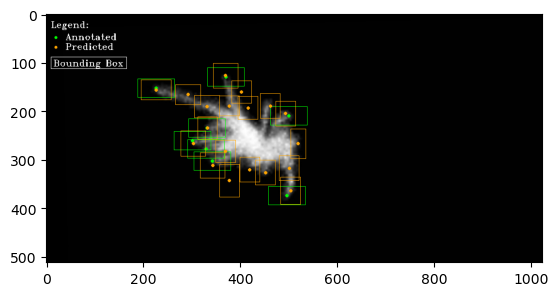

In [2]:
#example of how the bounding box looks like on the origninal image
example="R1_P30_1_270"
vis_picture(filename="R6_P40_4",
            image_path="data/custom_philo_generated/images", 
            label_path="data/custom_philo_generated/labels",
            pred_label_path= "data/custom_philo_generated/predicted_labels2",
            output_path="output",
            show=True,
            bounding_box=True
            )

## Custom Data: Rotation and Info Extraction
In the next cell, the label files will be created and the original data will be elarged by rotating every image by for times 90 degrees. For data access please contact Eric Reifenstein. 

In [ ]:
 
#%%
# extract data from original files in the right format for yolov3 provided by Eric Reifenstein 

from tools import rotate_coord 
# from natsort import natsorted

### changing parameters:
boxsize = 0.06 # why this size?
rotate = True # to elarge the data x4 by adding 3 rotated versions of the image 

#where we downloaded the data in: 
original_pic_directory = "/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/original_data/Single_Live_PR_Pictures"
original_label_directory = "/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/original_data/Filopodia_Base_Quantification"

#where we need the data to be for the training: 
destiny_pic_directory = "data/custom_rot/images/"
destiny_label_directory = "/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3/data/custom_rot/labels/"
###

### get the data from the excel file and save it in the right format and place
# loop over receptors and time points
hours_save = [25, 30, 35, 40]
for rec in [1, 2, 3, 4, 5, 6]:
    print('Receptor ' + str(rec))
    if rec == 1 or rec == 2 or rec == 5 or rec == 6:
        hours = [27, 31, 36, 41]
    elif rec == 3:
        hours = [26, 30, 35, 40]
    elif rec == 4:
        hours = [27, 31, 36, 39]
    
    for hh, hour in enumerate(hours):
        print(str(hour) + ' hAPF')
        img_paths = natsorted(glob.glob(original_pic_directory + '/R' + str(rec) + '/P' + str(hours_save[hh]) + '/*'))
        datpath = original_label_directory + '/R' + str(rec) + "/R"+ str(rec) + "_" + str(hour) + "hAPF.xlsx"
        
        if rec == 3: #load filopodia data from the excel file (split the data into subarrays based "X")
            if hh == 0:
                dat_fronts = pd.read_excel(datpath, usecols='D, E')
                dat_xfront, dat_yfront = np.array(dat_fronts['Unnamed: 3']), np.array(dat_fronts['Unnamed: 4'])
            else:
                dat_fronts = pd.read_excel(datpath, usecols='C, D')
                dat_xfront, dat_yfront = np.array(dat_fronts['Unnamed: 2']), np.array(dat_fronts['Unnamed: 3'])
        else:
            dat_fronts = pd.read_excel(datpath, sheet_name='Front and Front Filopodia', usecols='C, D')
            dat_xfront, dat_yfront = np.array(dat_fronts['Unnamed: 2']), np.array(dat_fronts['Unnamed: 3'])
        idx = np.where(dat_xfront=='X')[0]
        subarrs_front_x = np.split(dat_xfront, idx+1)[1:]
        subarrs_front_y = np.split(dat_yfront, idx+1)[1:]
        
        if rec != 3: 
            dat_heels = pd.read_excel(datpath, sheet_name='Heel and Heel Filopodia', usecols='C, D')
            dat_xheel, dat_yheel = np.array(dat_heels['Unnamed: 2']), np.array(dat_heels['Unnamed: 3'])
            idx = np.where(dat_xheel=='X')[0]
            subarrs_heel_x = np.split(dat_xheel, idx+1)[1:]
            subarrs_heel_y = np.split(dat_yheel, idx+1)[1:]
        
        for i, ip in enumerate(img_paths): #Load each image. Extract and process filopodia coordinates. Combine heel and front filopodia coordinates if applicable.
            img = cv2.imread(ip)

            xfil_front = np.array([elem for elem in subarrs_front_x[i] if isinstance(elem, (float, int)) and not np.isnan(elem)])[1:] # exclude front
            yfil_front = np.array([elem for elem in subarrs_front_y[i] if isinstance(elem, (float, int)) and not np.isnan(elem)])[1:]
            if rec == 3:
                xfil = xfil_front.copy()
                yfil = yfil_front.copy()
            else:
                xfil_heel = np.array([elem for elem in subarrs_heel_x[i] if isinstance(elem, (float, int)) and not np.isnan(elem)])[1:-1] # exclude heel and core border dot
                yfil_heel = np.array([elem for elem in subarrs_heel_y[i] if isinstance(elem, (float, int)) and not np.isnan(elem)])[1:-1]
                if rec == 5:
                    xfil = np.r_[xfil_heel, xfil_front]
                    yfil = 512 - np.r_[yfil_heel, yfil_front]
                else:
                    xfil = np.r_[xfil_heel, xfil_front]
                    yfil = np.r_[yfil_heel, yfil_front]
            
            # plt.figure()
            # plt.imshow(img)
            # plt.scatter(xfil, yfil)
            
        ### create 3 rotated versions of the image
        # rotate the data
            if rotate: 
                img_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                x90, y90 = rotate_coord(xfil-512, yfil-256, np.pi/2)
                x90 += 256
                y90 += 512

                img_180 = cv2.rotate(img, cv2.ROTATE_180)
                x180, y180 = rotate_coord(xfil-512, yfil-256, np.pi)
                x180 += 512
                y180 += 256

                img_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                x270, y270 = rotate_coord(xfil-512, yfil-256, -np.pi/2)
                x270 += 256
                y270 += 512

        # original data save 
            # save image 
            filename = "R"+str(rec)+"_P"+str(hours_save[hh])+"_"+str(i)
            cv2.imwrite(destiny_pic_directory + filename + ".jpg", img)    

            # save labels
            f = open(destiny_label_directory + filename + ".txt", "w")
            for j in range(len(xfil)):
                # label_idx x_center y_center width height
                # f.write("0 " + str(xfil[j]/1024) + ' ' + str(yfil[j]/512) + ' ' + str(25/1024) + ' ' + str(25/512) + '\n')
                f.write("0 " + str(xfil[j]/1024) + ' ' + str(yfil[j]/512) + ' ' + str(boxsize) + ' ' + str(boxsize) + '\n')
            f.close()

            if rotate: 
                # 90 degrees rotateted data save 
                filename = "R"+ str(rec) +"_P"+str(hours_save[hh])+"_"+str(i)+'_90'
                cv2.imwrite(destiny_pic_directory + filename + ".jpg", img_90)    

                # save labels for training
                f = open(destiny_label_directory + filename + ".txt", "w")
                for j in range(len(xfil)):
                    # label_idx x_center y_center width height
                    # f.write("0 " + str(xfil[j]/1024) + ' ' + str(yfil[j]/512) + ' ' + str(25/1024) + ' ' + str(25/512) + '\n')
                    f.write("0 " + str(x90[j]/512) + ' ' + str(y90[j]/1024) + ' ' + str(boxsize) + ' ' + str(boxsize) + '\n')
                f.close()

                # 180 degrees rotateted data save
                filename = "R"+str(rec)+"_P"+str(hours_save[hh])+"_"+str(i)+'_180'
                cv2.imwrite(destiny_pic_directory + filename + ".jpg", img_180)    

                # save labels
                f = open(destiny_label_directory + filename + ".txt", "w")
                for j in range(len(xfil)):
                    # label_idx x_center y_center width height
                    # f.write("0 " + str(xfil[j]/1024) + ' ' + str(yfil[j]/512) + ' ' + str(25/1024) + ' ' + str(25/512) + '\n')
                    f.write("0 " + str(x180[j]/1024) + ' ' + str(y180[j]/512) + ' ' + str(boxsize) + ' ' + str(boxsize) + '\n')
                f.close()

                # 270 degrees rotateted data save
                filename = "R"+str(rec)+"_P"+str(hours_save[hh])+"_"+str(i)+'_270'
                cv2.imwrite(destiny_pic_directory + filename + ".jpg", img_270)

                # save labels for training
                f = open(destiny_label_directory + filename + ".txt", "w")
                for j in range(len(xfil)):
                    # label_idx x_center y_center width height
                    # f.write("0 " + str(xfil[j]/1024) + ' ' + str(yfil[j]/512) + ' ' + str(25/1024) + ' ' + str(25/512) + '\n')
                    f.write("0 " + str(x270[j]/512) + ' ' + str(y270[j]/1024) + ' ' + str(boxsize) + ' ' + str(boxsize) + '\n')
                f.close()

## Generated Data ##
As a data augmentation tool, generated data can be added.
Please check ./data/generated/, where you will find:

    /images folder: Contains the generated images.
    /label folder: Contains the corresponding annotations in the required YOLOv3 format.

To introduce a distance measurement for filtering overlapping filopodia during the generation process, an unfinished version of the implementation can be found in ./d_generated.py.

Generated data was not used in the filopodia tip detection search by Vinzent Aschir due to poor performance.

A mix of custom rotation data and 1,000 generated images can be manually created in e.g. ./data/custom_philo_generated by adding the generated and the customized images and labels in their corresponding files. the subcategories /images and /label have to be maintained for the usage of YOLOv3
Its creation code was provided by Eric Reifenstein.

the following cell will conclude the difference of including generated data

Image saved: ./output



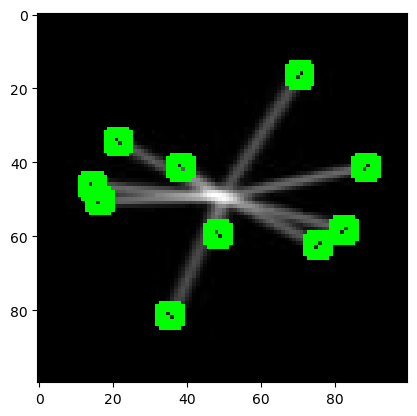

In [2]:

example="R1_P30_1_270"
vis_picture(filename="0021",
            image_path="data/custom_philo_generated/images", 
            label_path="data/custom_philo_generated/labels",
            pred_label_path= None,  #"data/custom_philo_generated/predicted_labels2",
            output_path="output",
            show=True,
            bounding_box=True
            )

the image of the generated "cell" number 0021 shows us that smaller filopodia can end within longer ones. the distance measurement of try to eliminate the creation of such overlapping filopodia in their creation process. (./d_generated.py)

## Tools ##

### copy/move tool: tool for shifting all the images from one folder to another one in parallel

./change_dir.sh  
<type: bolean, delete old directory>  
<type: directory, origin directory>  
<type: directory, destination directory>  
<type: bolean, copy already existing files>

In [ ]:
%%bash 
# ./change_dir.sh false "/data/custom_philo_generated/labels" "data/custom_philo_generated/edit_labels" true

In [ ]:
#via python: 
cur_dir= "./data/custom_philo_generated/labels_edit/"
bounding_box_custom = 0.06 #bounding box size custom data 
bb_gen = 0.05 # bounding box size generated data (none in our data) 

change_bb_cmd = [ #comand we wanna get excecuted by bash: 
    "./bounding_box_resize.sh", cur_dir, str(bounding_box_custom), str(bb_gen)
]
#subprocess.run(change_bb_cmd) #run the command

### bounding box resize tool: tool for changing uniformly the assigned bounding box in custom and/ or in generated data


./bounding_box_resize.sh  
<type: directory, the directory in which every label should be changed>  
<type: float, relative bounding box size (quadrat) to assign to custom data>  
<type float, relative bounding box size (quadrat) to assign to generated data>

In [ ]:
%%bash 
#edit bounding box 
#now let's change the bounding box size in the folder edit_labels. to the recommended 0.06 for custom data and 0.05 for generated data. 

#./bounding_box_resize.sh "data/custom_philo_generated/edit_labels" 0.06 0.05

In [ ]:
#in python: 
cur_dir= "./data/custom_philo_generated/labels_edit/" #where the labels are saved
bounding_box_custom = 0.06 #bounding box size custom data 
bb_gen = 0.05 # bounding box size generated data (none here) 

change_bb_cmd = [ #comand we wanna get excecuted by bash: 
    "./bounding_box_resize.sh", cur_dir, str(bounding_box_custom), str(bb_gen)
]
#subprocess.run(change_bb_cmd) #run the command

### visualisation tool

<type: str, filename of the image to visualize (without extension)>  
<type: str, directory of images>  
<type: str, directory of manual labels>  
<type: str or None, directory of predicted labels (optional)>  
<type: str, directory where the output image will be saved>  
<type: bool, display the image>  
<type: bool, draw bounding boxes on a detection>  
<type: float or None, accepted distance radius for midpoints (optional)>  

Image saved: ./visualisation



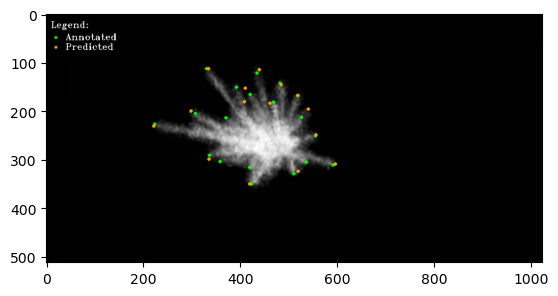

In [ ]:

example="R2_P35_1"#R1_P30_1_270, R5_P40_10_270 R6_P28_8 R6_P35_9_270 R1_P35_0
vis_picture(filename="R6_P35_5.jpg",
            image_path="data/custom_rot/images", 
            label_path="data/custom_rot/labels",
            pred_label_path="data/custom_rot/predicted_labels_a_base",
            output_path="visualisation",
            show=True,
            bounding_box=False, #show bounding box
            ac_d= None #15 # accepted distance drawn at 15 
            )


## Train the Model ##

### train-valid-split ###

whatever data you use, the chosen directory has to have a valid.txt and a train.txt file where the filenames of the corresponding group are written. 
Addionally, a class.names file has to be in the data directory.
./data/custom_rot serves as an good example.
The python function write_train_valid() from tools.py can write the wished amount of data of the correct and randomly shuffeled datasets in the train.txt and valid.txt files.

write_train_valid()  
<type: str, directory of analyzed data>  
<type: float,relative amount of data that is considered to be part of the validation set>  
<type: bool, should the validation set contain only custom and no generated data?>  
<type: int or -1, seed, -1 for random seed> 

In [15]:
# write train and valid file: (90% train, 10% validation)
# 
x_n_data, xval, xcust_only = write_train_valid(
    directory="./data/custom_rot",
    val=0.1,
    cust_only=True,
    seed=xseed)

total amount of images:  10 validation amount:  1 training amount:  9


In [12]:
# old function that does the same as a bash script without the addon of using only custom data
ac_dir ="./data/custom_rot"

#run the bash script to create the train file in the config folder (makes also the .names file if not present): 
# ! ./make_train_file.sh $ac_dir 

### Training ###

In [ ]:
#train the model: 
# import subprocess
# import os

# parameters for the training with baseline for training: 
x_model = "config/yolov3-tiny-custom.cfg" 
x_data = "config/custom_rot.data"
x_epochs = 30
x_iou_thres = 0.5 
x_conf_thres = 0.1 
x_nms_thres = 0.5
x_pretrained_weights = None # "checkpoints/yolov3_ckpt_25.pth"
x_multi_scale = True

#for further paramater settings and the actual yolov3 cmd have a look at the train_yolo.py file.
# adjusting them in this variables has the benefit of storing them automatically correctly in the csv file. 

training_cmd = [ #the command we wanna execute in a bash environment in a subprocess. 
    "poetry", "run", "python", "train_yolo.py",
    "--model", x_model,
    "--data", x_data,
    "--epochs", str(x_epochs),
    "--iou_thres", str(x_iou_thres),
    "--conf_thres", str(x_conf_thres),
    "--nms_thres", str(x_nms_thres),
    "--seed", str(xseed),
    "--n_cpu", str(1), #this is nessesary for not killing the data loader in the training.
    '--checkpoint_interval', str(5),
    #'--pretrained_weights', str(x_pretrained_weights), # comment this out if pretrained_weights is none.   
    "--multiscale_training" if x_multi_scale else ''
]
#start the training in a subprocess: 
process = subprocess.Popen(training_cmd) # create a new subprocess that the training doesn't affect the notebook. 

#for tracking the training process: 
#TensorBoard_cmd = ["poetry", "run", "tensorboard", "--logdir=logs", "--port=6006"]
#TensorBoard_process = subprocess.Popen(TensorBoard_cmd) # start the tensorboard for showing the progress.

process.wait() # waiting until the subprocess and the training ended. 

tmp_file_path = 'train.tmp'
if os.path.exists(tmp_file_path): 
    with open(tmp_file_path, 'r') as f:
        x_train_time = f.read().strip()
        os.remove(tmp_file_path)
else:        
    raise FileNotFoundError("The subprocess hasn't ended yet. The tmp file does not exist.")

# command for starting the training in a shell:

#! poetry run python train_yolo.py --model $x_model  --data $x_data --epochs $x_epochs --iou_thres $x_iou_thres --conf_thres $x_conf_thres --nms_thres $x_nms_thres --seed $xseed --pretrained_weights $x_pretrained_weights --multiscale_training

#track the training process: 
#!poetry run tensorboard --logdir='logs' --port=6006 #requires tensorboard and an poetry environment
# see the process in the browser: http://localhost:6006/


NameError: name 'xseed' is not defined

### Clean Up after Training ### 

In [ ]:
# this cell is to move the weights (checkpoints) to the another folder that they can't be overwritten with further training processes: 
ac_dir = "./data/custom_rot" 
dest_dir = ac_dir + "/train_conf_thres/0.15" 

! ./change_dir.sh true "./checkpoints/" $dest_dir true  

/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3/data/custom_rot/train_conf_thres/0.15 doesn_t exist yet.
chmod: cannot access '755': No such file or directory

all 6 files copied from ./checkpoints/ to /mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3/data/custom_rot/train_conf_thres/0.15
content deleted at: ./checkpoints/


In [ ]:
# kill the subprocess with the training that we started in the background. 
process.terminate()
if os.path.exists("train.tmp"):
    os.remove("train.tmp") 

## Evaluation ## 

evaluation based on the detect_picture() function in ./tools.py. Detect_picture uses the intial pytorchyolo/detect.detect_image() function from the yolov3 implementation to predict filopodia midpoints of one image. The predicted coordinates can be safed according to the yolov3 label format in predicted_label directory and a visualisaiton can be showed and stored as well. Additionally, A statistical analysis of the performed training is conducted. For further explanation have a look in the thesis of Vinzent Aschir or look in the implementation in ./tools.py. 

the model has to be loaded first with the rigth checkpoints from training. weights are also allowed

detect_picture()  
<type: str, filename of the single cell that should be analysed without format ending>  
<type: str, directory of the analyzed images>  
<type: str or None, directory where the predicted labels should be stored >     
<type: model or None, model that is already loded to save time>  
<type: float, confidence threshold for evaluation ranging between 0 and 1>  
<type: float, Non-maximum-Supression threshold for evaluation ranging between 0 and 1>  
<type: int, accepted_distance in px that a predicted midpoint can differ from the original annotation to be considered as an correct prediction>   
<type: str or None, directory where to store the visualisation of the prediction with annotation if show= true>  
<type: bool, bounding box visualisation: should we draw the bounding box in the images?>  
<type: bool, show: should we show the steps and the visualisation?>  
<type: int or None, draw the accepted range with the corresponding value, if bounding box is false?>  

/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/ba_thesis_aschir/pytorchyolo/models.py:340: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch

created the output reposistory: ./data/custom_rot/predicted_labels2
R2_P30_3
TP:  10 , FP:  2 , FN:  1 , OD:  0 , NH:  2 , Sensitivity:  0.909091 , predicted points:  12 , manual points:  11



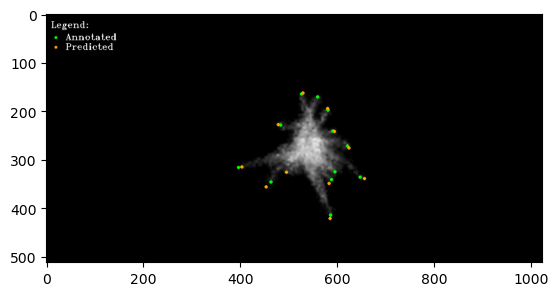

In [ ]:
# Evaluation of one image: detect_picture()

#future work: 
#in the statistics: we should look ip in the matrix which coloumn didnt didnt got a minimum. that we can mark all the points in a different color for example that were over detected. 
# change the calculation of Tp, FP ... in a implementation using dicts for a unique assignment in over detection. 
# change the definition of over-detection-rate to consider them as FP. 
# constructing an estimator which points were not detected or which prediction can be added to the original annotation. 
# e.g. calculatong the amount of white in a bounding box and using it for filtering predictions that are considered to be added in the ground-truth. 
 
 
# from scipy.spatial import distance
# from tools import * 
# from pytorchyolo import detect, models 
model=models.load_model("config/yolov3-tiny-custom.cfg", "checkpoints/baseline_100.pth")
detect_picture(filename="R2_P30_3",
               img_path = "./data/custom_rot/images",
               pred_label_path = "./data/custom_rot/predicted_labels2",
               model = model, # load model in advance: models.load_model("config/yolov3-tiny-custom.cfg", "data/custom_philo_generated/checkpoints100/yolov3_ckpt_100.pth"),
               conf_thres=0.01,
               nms_thres=0.1,
               accepted_distance = 15, # how many pixels are allowed between annotated and predicted point to be wrong?
               stat_all_pics= None, # for statistics is there an statistix object to store over every picture? 
               output= None, # for visualisation: where should we store the visualized picture? None is possible! 
               bounding_box = False, # for visualisation: should we show the bounding box?
               show = True,
               ac_d = None)

# detect_picture(filename="R3_P40_13", stat_all_pics=mystats,show=False)
# detect_picture(filename="0022", img_path= "./custom_philo_generated/images", stat_all_pics=mystats)

In [19]:
# Evaluation over all the images:   

# from pytorchyolo import detect, models
# from tools import statistix, stat_pic, vis_picture
# from datetime import datetime

start_time = datetime.now() #for tracking the compilation time

all_stats = statistix() # create a statistic object 

file_val = open("data/custom_rot/valid.txt", "r")
val_paths = file_val.readlines()
file_val.close()

# Parameter:
ev_conf_thres=0.01
ev_nms_thres=0.1
ev_accepted_distance=15
model = models.load_model("config/yolov3-tiny-custom.cfg", "checkpoints/baseline_100.pth") #load the trained model with its weights

#now we go through all the pictures we wanna add to the statistics: 
for val_file in val_paths:
    val_file = val_file.split('/')[-1]
    detect_picture(filename= val_file.rstrip(),
                   img_path = "data/custom_rot/images",
                   pred_label_path = "data/custom_rot/predicted_labels",
                   model = model, #we use the once loaded model from the cell above to not waist time. 
                   conf_thres=ev_conf_thres,
                   nms_thres=ev_nms_thres,
                   accepted_distance = ev_accepted_distance,
                   stat_all_pics= all_stats, 
                   show = False
                )
    
#stop the compilation time
end_time = datetime.now()
duration = end_time - start_time 
#formatting time to string: 
duration_seconds = duration.total_seconds()
duration_str = seconds_to_time(duration_seconds)

print('Duration:', duration_str)
all_stats.print_values()

#save the statistics results as variables for the csv file: 
x_n_not_annotated, x_sens, x_over_det_rate, x_no_hit_p_rate = all_stats.x_get_values()


Duration: 0d/0h/0m/1.28s

 Number of pictures:  1 Number of not annotated pictures: 0 , Sensitivity:  0.714286 , over detection rate:  0.0 , no-hit-point-rate:  0.285714 



### Visual Breakdown 10 cells


Here is a visual breakdown of ten cells to see the acceptance range of an hitpoint.
The thresholds can be adjusted based on the prefference of not having to many _FP_ or or not so many _TP_.

Also check on how strict you wanna be with the acceptance distance by looking into folder *visalisation/acceptance_distance*

In [ ]:
# visual breakdown 10 pic 

#parameters
ev_conf_thres=0.01
ev_nms_thres=0.1
ev_accepted_distance=15
model = models.load_model("config/yolov3-tiny-custom.cfg", "checkpoints/baseline_100.pth") 

#since while the creation of valid.txt, we already shuffeled randomly, we will pick now the first 10 cells of valid.txt
file_val = open("data/custom_rot/valid.txt", "r")
val_paths = file_val.readlines()
file_val.close()

for i in range(10): 
    detect_picture(filename= val_paths[i].rstrip().split('/')[-1],
                   img_path = "data/custom_rot/images",
                   pred_label_path = "data/custom_rot/predicted_labels",
                   model = model,
                   conf_thres=ev_conf_thres,
                   nms_thres=ev_nms_thres,
                   accepted_distance = ev_accepted_distance,
                   stat_all_pics= None, 
                   output=output,
                   show = True
                )

cp: target 'checkpoint/basline_100.pth': No such file or directory


/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3/pytorchyolo/models.py:340: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t

IndexError: list index out of range

## List Setup for storing information: ## 

In [21]:
#current Date, Gpu, is wsl, cwd in windows
import torch
# from datetime import datetime
# import os

# current time 
now = datetime.now()
current_time = now.strftime("%Y-%m-%d %H:%M:%S") #format the time 

# current gpu if cuda: 
x_gpu =torch.cuda.get_device_name(0) # extract the gpu name 

#current working env 
def detect_environment():
    in_wsl = False
    in_windows = False

    # check if running in wsl:
    try:
        with open("/proc/sys/kernel/osrelease", "r") as f:
            in_wsl = "WSL" in f.read()
    except FileNotFoundError:
        pass

    # check if current working directory is in windows:
    cwd = os.getcwd()
    in_windows = cwd.startswith("/mnt/")
    
    return in_wsl, in_windows

in_wsl, in_windows = detect_environment()
print("shell in wsl: ", in_wsl, "cwd in windows: ", in_windows)
print(x_gpu)
print("current time:", current_time)

RuntimeError: No CUDA GPUs are available

the following cells redefines some of the parameters that you dont have to rerun all the cells for finding the missing variables. the disadvantage is, that you have to set each variable setting manually

In [ ]:
# skip cell: parameter definition
x_data= "config/custom_rot.data"
x_train_time ="0d/13h/15m/43s" # time of baseline 100
x_model= "config/yolov3-tiny-custom.cfg"
x_epochs= 30
x_pretrained_weights=None
x_iou_thres= 0.5
x_conf_thres= 0.1
x_nms_thres= 0.5
x_multi_scale= True
xseed= 42

rotate=True
boxsize=0.06
x_n_gen=None
x_bb_gen=None

k_cross_val=1
xcust_only=True

In [ ]:
key="ev_conf_thres" #the key is a field for metadata, to group multiple rows belonging together. 

In [ ]:
#check parameters: that all values are correct before adding them to the csv file?

# verify if these are the parameters you used for the data: 
print(f"key: {key}\n")

print(f" the data parameters: \n \
    data: {x_data}\n \
    custom pictures are rotated: {rotate}\n \
    bounding-box-size for custom data: {boxsize}\n \
    amount of generated data included in the training process: {x_n_gen}\n \
    bounding_box-size used for the generated data: {x_bb_gen}\n \
    amount of pictures in the data: {x_n_data}\n \
    percentage of data used for validation: {xval}\n \
    did we use only custom data for the validation (no generated): {xcust_only}\n")

# verify if these are the parameters you used for the training:
print(f"the training parameters: \n \
    the neuronal network model: {x_model}\n \
    how many epochs were trained:  {x_epochs}\n \
    pretrained weights: {x_pretrained_weights} \n \
    did you use the built-in multiscaling tool for elarging your data: {x_multi_scale} \n \
    training iou threshold: {x_iou_thres} \n \
    training confidence threshold: {x_conf_thres} \n \
    training nms threshold: {x_nms_thres}\n")

# verify if these are the general notebook settings you used/achieved:
print(f"the general notebook settings: \n \
    the used seed in your notebook: {xseed}\n \
    the current date and time: {current_time}\n \
    the time the training took: {x_train_time}\n \
    the time the evaluation took: {ev_time}\n \
    the k-fold cross validation you used: {k_cross_val}\n \
    the gpu you used: {x_gpu}\n \
    shell im wsl: {in_wsl} \n \
    current working directory in windows: {in_windows}\n")

# verify if these are the achieved values and used parameters for the statistic:
print(f"the statistical result/ parameters: \n \
    cells were not annotated and excluded in the statistics: {x_n_not_annotated}\n \
    sensitivity: {round(x_sens, 4)}\n \
    over detection rate: {round(x_over_det_rate, 4)}\n \
    no hit point rate: {round(x_no_hit_p_rate, 4)}\n")

# verify if these are the parameters you used for the evaluation:
print(f"the evaluation parameters: \n \
    confidence threshold for the evaluation: {ev_conf_thres}\n \
    nms threshold for the evaluation: {ev_nms_thres}\n \
    accepted distance for the evaluation: {ev_accepted_distance}\n")


key: ev_conf_thres

 the data parameters: 
     data: config/custom_rot.data
     custom pictures are rotated: True
     bounding-box-size for custom data: 0.06
     amount of generated data included in the training process: None
     bounding_box-size used for the generated data: None
     amount of pictures in the data: 1416
     percentage of data used for validation: 0.1
     did we use only custom data for the validation (no generated): True

the training parameters: 
     the neuronal network model: config/yolov3-tiny-custom.cfg
     how many epochs were trained:  30
     pretrained weights: None 
     did you use the built-in multiscaling tool for elarging your data: True 
     training iou threshold: 0.5 
     training confidence threshold: 0.1 
     training nms threshold: 0.5



NameError: name 'current_time' is not defined

## CSV editings ## 

if you checked all the Parameters above, for your training process, then you can add them to your csv file.

In [ ]:
# create csv: 
# import csv 
with open('train_conf_thres2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ["key", 
             "data", "custom_rotated", "bounding_box_custom", "n_generated", "bounding_box_generated", "n_data",	"val_perc", "val_cust_only",
             "train_model", "train_epochs", "train_pretrained_weights", "train_multiscale_training", "train_iou_thres", "train_conf_thres", "train_nms_thres",
             "seed", "gpu", "current_time", "training_time", "ev_time", "k_cross_val", "shell_in_wsl", "cwd_in_windows",
             "n_not_annotated", "sens", "over_detecion_rate", "no_hit_point_rate",
             "ev_conf_thres", "ev_nms_thres", "accepted_dist"]
    writer.writerow(field)
file.close()

In [ ]:
# add an line to the csv file: 
# the key is a field for comments as metadata, for marking different cells belonging together. 
with open('train_conf_thres.csv', 'a', newline='') as file:
    writer= csv.writer(file)
    writer.writerow([key,
                     x_data, rotate, boxsize, x_n_gen, x_bb_gen, x_n_data, xval, xcust_only,
                     x_model, x_epochs, x_pretrained_weights, x_multi_scale, x_iou_thres, x_conf_thres, x_nms_thres,
                     xseed, x_gpu, current_time, x_train_time,ev_time, k_cross_val, in_wsl, in_windows,
                     x_n_not_annotated, x_sens, x_over_det_rate, x_no_hit_p_rate,
                     ev_conf_thres, ev_nms_thres, ev_accepted_distance])
    

In [ ]:
# import pandas as pd

def csv_delete_row(doc='train_documentation.csv', index=-1):	#needs pandas library as pd 
    #checks if input is an csv file: 
    is_csv=doc.lower().endswith('.csv')
    if not is_csv:
        raise TypeError("The input file is not a csv file.")
    else:
        df = pd.read_csv('train_documentation.csv')
        df = df.drop(df.index[-1]) #delete last column else change -1 to specified index. 
        df.to_csv('train_documentation.csv', index=False)

def csv_delete_by_key(doc='train_documentation.csv', key="test"): #needs pandas library as pd 
    #checks if input is an csv file: 
    is_csv=doc.lower().endswith('.csv')
    if not is_csv:
        raise TypeError("The input file is not a csv file.")
    else:
        df = pd.read_csv(doc)
        df = df[df.key != key] #delete last column else change -1 to specified index. 
        df.to_csv(doc, index=False)


csv_delete_row()



# Lets visualize the results: in the example train_nms_thres 

In [ ]:
# Visualization of the r3 Data, where heel filopodia are not annotated. 
# 
import glob
import re

directory = "/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3/data/custom_rot/images"

# store all R3 files 
all_files = glob.glob(f"{directory}/R3*.jpg") 

# filtering the rotations out with regular expression: "R3_P<number>_<number>.jpg" for 
pattern = re.compile(r"^R3_P\d+_\d+\.jpg$") 

r3_files = [os.path.basename(f) for f in all_files if pattern.search(f.split('/')[-1])]
print("amount of R3 images:", len(r3_files))
#print(filtered_files)

for i in r3_files: 
    vis_picture(filename=i,
        image_path="data/custom_philo_generated/images", 
        label_path="data/custom_philo_generated/labels",
        pred_label_path=None,
        output_path= None, # "visualisation/R3",
        show= False,
        bounding_box=True)


In [3]:
#all custom_rot data: Visualization and evaluation of 
from datetime import datetime
start_time = datetime.now()
#baseline parameters:
val_perc=1
cust_only=True 
x_seed=42
data= "data/custom_rot"

x_ev_conf_thres=0.01
x_ev_nms_thres=0.1
x_ev_accepted_distance=15
x_model = models.load_model("config/yolov3-tiny-custom.cfg", "checkpoints/baseline_100.pth")
bounding_box_custom = 0.06

#create an statistic object for evaluation. 
stat_all = statistix()

#have a look at the dir of this variable: 
visualisation = "data/custom_rot/visualisaion_base_all"
write_train_valid(directory= data, val=val_perc, cust_only=cust_only, seed=x_seed)

file_val = open(data+"/valid.txt", "r")
val_paths = file_val.readlines()
file_val.close()

for val_file in val_paths:
    val_file= val_file.split('/')[-1]
    detect_picture(filename= val_file.rstrip(),
               img_path = data + "/images",
               pred_label_path =  data + "/predicted_labels_a_base",
               model = x_model, #models.load_model("config/yolov3-tiny-custom.cfg", "data/custom_philo_generated/checkpoints100/yolov3_ckpt_100.pth"),
               conf_thres=x_ev_conf_thres,
               nms_thres= x_ev_nms_thres,
               accepted_distance = x_ev_accepted_distance, # how many pixels are allowed between annotated and predicted point to be wrong?
               stat_all_pics= stat_all, # for statistics is there an statistix object to store over every picture? 
               output=visualisation, # for visualisation: where should we store the visualized picture? None is possible! 
               bounding_box = False, # for visualisation: should we show the bounding box?
               show = False, 
               ac_d=x_ev_accepted_distance #for visualisation: accepted distance between annotated and predicted point
        )
#stop the compilation time
end_time = datetime.now()
duration = end_time - start_time 

# Calculate duration in d/h/m/s format
days = duration.days
hours, remainder = divmod(duration.seconds, 3600)
minutes, seconds = divmod(remainder, 60)
duration_str = f"{days}d/{hours}h/{minutes}m/{seconds}s"
ev_time=duration_str
# Print the duration
print('Duration:', duration_str)
### hier müssen wir alle daten noch in Variablen abspeichern um sie in eine xlx datei zu speichern. 
stat_all.print_values()
x_n_not_annotated, x_sens, x_over_det_rate, x_no_hit_p_rate = stat_all.x_get_values()

/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3/pytorchyolo/models.py:340: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t

total amount of images:  1416 validation amount:  1416 training amount:  0
Duration: 0d/0h/3m/8s


NameError: name 'all_stats' is not defined

In [6]:
csv_file_path= "train_documentation.csv" 

#read the csv file:
df = pd.read_csv(csv_file_path) 
df.head() #show the first 5 rows of the csv file.


,key,data,custom_rotated,bounding_box_custom,n_generated,bounding_box_generated,n_data,val_perc,val_cust_only,train_model,...,training_time,ev_time,k_cross_val,n_not_annotated,sens,over_detecion_rate,no_hit_point_rate,ev_conf_thres,ev_nms_thres,accepted_dist
0,first_baseline,config/custom_rot.data,True,0.06,NaN,NaN,1416,0.1,True,config/yolov3-tiny-custom.cfg,...,0d/2h/45m/1s,NaN,1,53,0.642523,0.193146,0.034368,0.01,0.1,35


Bild mit Bounding Boxes gespeichert: output



ValueError: There are no manual points in this picture.

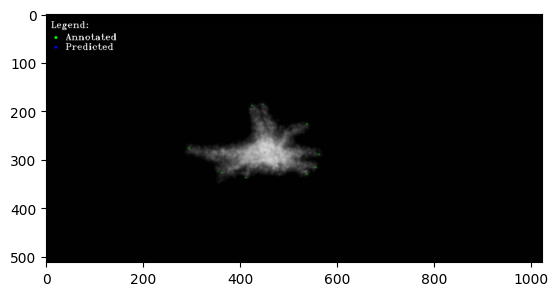

In [32]:
#Graph: checkpoints - this cell is to find out which amount of checkpoints is the best for the model. 
#Auswertung und erstellen der Statistik über alle Bilder  

from pytorchyolo import detect, models
import importlib
import tools  
importlib.reload(tools) 
from tools import statistix, stat_pic, vis_picture
from datetime import datetime

file_val = open("data/custom_rot/valid.txt", "r")
val_paths = file_val.readlines()
file_val.close()

for ckpt in range(1, 101,2): #go through all the checkpoints from 1 to 100 in steps of 5. 
    #for tracking the compilation time
    start_time = datetime.now()

    model = models.load_model("config/yolov3-tiny-custom.cfg", f"checkpoints/yolov3_ckpt_{ckpt}.pth") #load the trained model with its weights

    all_stats = statistix() # create a statistic object 

    
    #now we go through all the pictures we wanna add to the statistics: 
    # Parameter:
    ev_conf_thres=0.5
    ev_nms_thres=0.5
    ev_accepted_distance=15

    for val_file in val_paths:
        val_file = val_file.split('/')[-1]
        detect_picture(filename= val_file.rstrip(),
                    img_path = "/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3/data/custom_rot/images",
                    pred_label_path = "/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3/data/custom_rot/predicted_labels",
                    model = model, #we use the once loaded model from the cell above to not waist time. 
                    conf_thres=ev_conf_thres,
                    nms_thres=ev_nms_thres,
                    accepted_distance = ev_accepted_distance,
                    stat_all_pics= all_stats, 
                    show = False
                    )
    #stop the compilation time
    end_time = datetime.now()
    duration = end_time - start_time 

    # Calculate duration in d/h/m/s format
    days = duration.days
    hours, remainder = divmod(duration.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    duration_str = f"{days}d/{hours}h/{minutes}m/{seconds}s"
    ev_time=duration_str
    # Print the duration
    print('Duration:', duration_str)
    ### hier müssen wir alle daten noch in Variablen abspeichern um sie in eine xlx datei zu speichern. 
    all_stats.print_values
    x_n_not_annotated, x_sens, x_over_det_rate, x_no_hit_p_rate = all_stats.x_get_values()
    
    x_epochs=ckpt
    #write to csv: 
    with open('baseline_ckpts.csv', 'a', newline='') as file:
        writer= csv.writer(file)
        writer.writerow([key,
                         x_data, rotate, boxsize, x_n_gen, x_bb_gen, x_n_data, xval, xcust_only,
                         x_model, x_epochs, x_pretrained_weights, x_multi_scale, x_iou_thres, x_conf_thres, x_nms_thres,
                         xseed, x_train_time,ev_time, k_cross_val,
                         x_n_not_annotated, x_sens, x_over_det_rate, x_no_hit_p_rate,
                         ev_conf_thres, ev_nms_thres, ev_accepted_distance])
    





In [1]:
#Graph: ev nms threshold:
#Graph: checkpoints - this cell is to find out which amount of checkpoints is the best for the model. 
#Auswertung und erstellen der Statistik über alle Bilder  

from pytorchyolo import detect, models
import importlib
import tools  
importlib.reload(tools) 
from tools import statistix, stat_pic, vis_picture
from datetime import datetime

file_val = open("data/custom_rot/valid.txt", "r")
val_paths = file_val.readlines()
file_val.close()

nms_steps =  np.arange(0.6, 1, 0.01)  # Note: The stop value is exclusive, so use 0.6 to include 0.5


for step in nms_steps: #go through all the checkpoints from 1 to 100 in steps of 5. 
    #for tracking the compilation time
    start_time = datetime.now()

    model = models.load_model("config/yolov3-tiny-custom.cfg", "checkpoints/yolov3_ckpt_100.pth") #load the trained model with its weights

    all_stats = statistix() # create a statistic object 

    
    #now we go through all the pictures we wanna add to the statistics: 
    # Parameter:
    ev_conf_thres=0.01
    ev_nms_thres=step
    ev_accepted_distance=15

    for val_file in val_paths:
        val_file = val_file.split('/')[-1]
        detect_picture(filename= val_file.rstrip(),
                    img_path = "/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3/data/custom_rot/images",
                    pred_label_path = "/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3/data/custom_rot/predicted_labels",
                    model = model, #we use the once loaded model from the cell above to not waist time. 
                    conf_thres=ev_conf_thres,
                    nms_thres=ev_nms_thres,
                    accepted_distance = ev_accepted_distance,
                    stat_all_pics= all_stats, 
                    show = False
                    )

    #compilation time
    end_time = datetime.now()
    duration = end_time - start_time 

    days = duration.days
    hours, remainder = divmod(duration.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    duration_str = f"{days}d/{hours}h/{minutes}m/{seconds}s"
    ev_time=duration_str

    print('Duration:', duration_str)
    ### hier müssen wir alle daten noch in Variablen abspeichern um sie in eine xlx datei zu speichern. 
    all_stats.print_values
    x_n_not_annotated, x_sens, x_over_det_rate, x_no_hit_p_rate = all_stats.x_get_values()
    
    x_epochs=100

    #write to csv: 
    with open('ev_nms_thres.csv', 'a', newline='') as file:
        writer= csv.writer(file)
        writer.writerow([key,
                         x_data, rotate, boxsize, x_n_gen, x_bb_gen, x_n_data, xval, xcust_only,
                         x_model, x_epochs, x_pretrained_weights, x_multi_scale, x_iou_thres, x_conf_thres, x_nms_thres,
                         xseed, x_train_time,ev_time, k_cross_val,
                         x_n_not_annotated, x_sens, x_over_det_rate, x_no_hit_p_rate,
                         ev_conf_thres, ev_nms_thres, ev_accepted_distance])
    





KeyboardInterrupt: 

In [11]:
#Graph: ev conf threshold:
#Graph: checkpoints - this cell is to find out which amount of checkpoints is the best for the model. 
#Auswertung und erstellen der Statistik über alle Bilder  

from pytorchyolo import detect, models
import importlib
import tools  
importlib.reload(tools) 
from tools import statistix, stat_pic, vis_picture, detect_picture
from datetime import datetime
import numpy as np 
import torch
from datetime import datetime
import os


file_val = open("data/custom_rot/valid.txt", "r")
val_paths = file_val.readlines()
file_val.close()

conf_steps = np.arange(0.15, 1.025, 0.025)  # 0.51 to include 0.5
#conf_steps = np.unique(np.concatenate((range1, range2)))

model = models.load_model("config/yolov3-tiny-custom.cfg", "checkpoints/yolov3_ckpt_100.pth") #load the trained model with its weights
ev_nms_thres=0.1
ev_accepted_distance=15
x_gpu = "NVIDIA GeForce MX450"
key= "ev_conf_thres"
x_epochs=100
in_wsl, in_windows = True, True 

for step in conf_steps: #go through all the checkpoints from 1 to 100 in steps of 5. 
    #for tracking the compilation time
    start_time = datetime.now()

    all_stats = statistix() # create a statistic object 

    #now we go through all the pictures we wanna add to the statistics: 
    # Parameter:
    ev_conf_thres=step

    for val_file in val_paths:
        val_file = val_file.split('/')[-1]
        detect_picture(filename= val_file.rstrip(),
                    img_path = "/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3/data/custom_rot/images",
                    pred_label_path = "/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3/data/custom_rot/predicted_labels",
                    model = model, #we use the once loaded model from the cell above to not waist time. 
                    conf_thres=ev_conf_thres,
                    nms_thres=ev_nms_thres,
                    accepted_distance = ev_accepted_distance,
                    stat_all_pics= all_stats, 
                    show = False
                    )

    #compilation time
    end_time = datetime.now()
    duration = end_time - start_time 

    days = duration.days
    hours, remainder = divmod(duration.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    duration_str = f"{days}d/{hours}h/{minutes}m/{seconds}s"
    ev_time=duration_str

    print(step)
    #print('Duration:', duration_str)
    ### hier müssen wir alle daten noch in Variablen abspeichern um sie in eine xlx datei zu speichern. 
    all_stats.print_values
    x_n_not_annotated, x_sens, x_over_det_rate, x_no_hit_p_rate = all_stats.x_get_values()

        # current time 
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d %H:%M:%S") #format the time 

    with open('train_conf_thres2.csv', 'a', newline='') as file:
        writer= csv.writer(file)
        writer.writerow([key,
                     x_data, rotate, boxsize, x_n_gen, x_bb_gen, x_n_data, xval, xcust_only,
                     x_model, x_epochs, x_pretrained_weights, x_multi_scale, x_iou_thres, x_conf_thres, x_nms_thres,
                     xseed, x_gpu, current_time, x_train_time,ev_time, k_cross_val, in_wsl, in_windows,
                     x_n_not_annotated, x_sens, x_over_det_rate, x_no_hit_p_rate,
                     ev_conf_thres, ev_nms_thres, ev_accepted_distance])
    
    





box: no predicted points in R4_P40_3
0.15
box: no predicted points in R4_P40_3
0.175
box: no predicted points in R6_P25_2_180
box: no predicted points in R4_P40_3
box: no predicted points in R4_P35_0
box: no predicted points in R4_P30_2_180
box: no predicted points in R5_P40_1
box: no predicted points in R2_P25_11
box: no predicted points in R4_P30_9_180
box: no predicted points in R4_P35_1_90
box: no predicted points in R1_P25_3_180
box: no predicted points in R1_P35_4_180
0.19999999999999998
box: no predicted points in R6_P25_8
box: no predicted points in R4_P25_10_180
box: no predicted points in R6_P30_5_180
box: no predicted points in R6_P25_2_180
box: no predicted points in R4_P40_3
box: no predicted points in R4_P35_0
box: no predicted points in R5_P25_3_90
box: no predicted points in R4_P30_2_180
box: no predicted points in R2_P25_10_90
box: no predicted points in R5_P35_4
box: no predicted points in R1_P30_2
box: no predicted points in R5_P40_1
box: no predicted points in R2_P2

In [31]:
#Graph: ev nms threshold:
#Graph: checkpoints - this cell is to find out which amount of checkpoints is the best for the model. 
#Auswertung und erstellen der Statistik über alle Bilder  

from pytorchyolo import detect, models
import importlib
import tools  
importlib.reload(tools) 
from tools import statistix, stat_pic, vis_picture
from datetime import datetime

file_val = open("data/custom_rot/valid.txt", "r")
val_paths = file_val.readlines()
file_val.close()

d_steps =  np.arange(50, 51, 1)  # Note: The stop value is exclusive, so use 0.6 to include 0.5


for step in d_steps: #go through all the checkpoints from 1 to 100 in steps of 5. 
    #for tracking the compilation time
    start_time = datetime.now()

    model = models.load_model("config/yolov3-tiny-custom.cfg", "checkpoints/yolov3_ckpt_100.pth") #load the trained model with its weights

    all_stats = statistix() # create a statistic object 

    
    #now we go through all the pictures we wanna add to the statistics: 
    # Parameter:
    ev_conf_thres=0.01
    ev_nms_thres=0.1
    ev_accepted_distance=step

    for val_file in val_paths:
        val_file = val_file.split('/')[-1]
        detect_picture(filename= val_file.rstrip(),
                    img_path = "/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3/data/custom_rot/images",
                    pred_label_path = "/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3/data/custom_rot/predicted_labels",
                    model = model, #we use the once loaded model from the cell above to not waist time. 
                    conf_thres=ev_conf_thres,
                    nms_thres=ev_nms_thres,
                    accepted_distance = ev_accepted_distance,
                    stat_all_pics= all_stats, 
                    show = False
                    )

    #compilation time
    end_time = datetime.now()
    duration = end_time - start_time 

    days = duration.days
    hours, remainder = divmod(duration.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    duration_str = f"{days}d/{hours}h/{minutes}m/{seconds}s"
    ev_time=duration_str

    print('Duration:', duration_str)
    print(step)
    ### hier müssen wir alle daten noch in Variablen abspeichern um sie in eine xlx datei zu speichern. 
    all_stats.print_values
    x_n_not_annotated, x_sens, x_over_det_rate, x_no_hit_p_rate = all_stats.x_get_values()
    
    x_epochs=100

    #write to csv: 
    with open('accepted_distance.csv', 'a', newline='') as file:
        writer= csv.writer(file)
        writer.writerow([key,
                         x_data, rotate, boxsize, x_n_gen, x_bb_gen, x_n_data, xval, xcust_only,
                         x_model, x_epochs, x_pretrained_weights, x_multi_scale, x_iou_thres, x_conf_thres, x_nms_thres,
                         xseed, x_train_time,ev_time, k_cross_val,
                         x_n_not_annotated, x_sens, x_over_det_rate, x_no_hit_p_rate,
                         ev_conf_thres, ev_nms_thres, ev_accepted_distance])
    





/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3/pytorchyolo/models.py:340: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t

Duration: 0d/0h/0m/20s
50


In [ ]:
glxinfo | grep "OpenGL renderer string" | sed -E 's/.*\(([^()]*)\)$/\1/'


In [27]:
x_iou_thres = 0.5